# Survival Analysis Sandbox - WHAS500

In [2]:
# Core libraries
import pandas as pd 
import numpy as np 
import seaborn as sb 
import matplotlib.pyplot as plt

# Survival analysis and datasets 
from lifelines import KaplanMeierFitter
import sklearn
import sksurv 
from SurvSet.data import SurvLoader 

# Other analysis
from tableone import TableOne

### Load in datasets 

In [3]:
loader = SurvLoader()
whas500, ref = loader.load_dataset(ds_name='whas500').values()
whas500.head()

,pid,event,time,num_age,num_hr,num_sysbp,num_diasbp,num_bmi,num_los,num_week,fac_gender,fac_cvd,fac_afb,fac_sho,fac_chf,fac_av3,fac_miord,fac_mitype,fac_year
0,0,0,2178,83,89,152,78,25.54051,5,3,M,1,1,0,0,0,1,0,1996-7
1,1,0,2172,49,84,120,60,24.02398,5,3,M,1,0,0,0,0,0,1,1996-7
2,2,0,2190,70,83,147,88,22.14290,5,1,F,0,0,0,0,0,0,1,1996-7
3,3,1,297,70,65,123,76,26.63187,10,8,M,1,0,0,1,0,0,1,1996-7
4,4,0,2131,70,63,135,85,24.41255,6,9,M,1,0,0,0,0,0,1,1996-7


### Descriptives of dataset using TableOne

In [7]:
tableOne_cols = ['num_age','num_hr','num_sysbp','num_diasbp','num_bmi','num_los','fac_gender','fac_cvd','fac_afb','fac_sho','fac_chf','fac_av3','fac_miord','fac_mitype']
tableOne_cat  = ['fac_gender','fac_cvd','fac_afb','fac_sho','fac_chf','fac_av3','fac_miord','fac_mitype']
tableOne_groupby = 'event'
tableOne_nonnormal = ['num_age','num_hr','num_sysbp','num_diasbp','num_bmi','num_los']

# Clean up labels, notes...
    ## Recurrent: 1 means pt has already had an MI 
    ## Q-wave MIs are transmural and are associated with worse survival
tableOne_labels = {'num_age':'Age',
                   'num_hr':'Heart Rate',
                   'num_sysbp':'Systolic BP',
                   'num_diasbp':"Diastolic BP",
                   'num_bmi':'BMI',
                   'num_los':'LoS',
                   'fac_gender':'Sex',
                   'fac_cvd':'Hx of CVD',
                   'fac_afb':'AFib',
                   'fac_sho':'Cardiogenic Shock',
                   'fac_chf':'Congestive Heart Failure',
                   'fac_av3':'Complete Heart Block',
                   'fac_miord':'Recurrent MI',
                   'fac_mitype':'MI Type (Q-Wave)'}

# Generate table along with footnotes of statistical tests
tableOne = TableOne(whas500, tableOne_cols, tableOne_cat, tableOne_groupby, tableOne_nonnormal,rename=tableOne_labels, 
                    dip_test=True, normal_test=True, tukey_test=True, pval=True)
tableOne

Grouped by event                                                                       
                                           Missing              Overall                    0                    1 P-Value
n                                                                   461                  285                  176        
Age, median [Q1,Q3]                              0     71.0 [58.0,81.0]     64.0 [53.0,74.0]     80.0 [72.0,86.0]  <0.001
Heart Rate, median [Q1,Q3]                       0    85.0 [69.0,100.0]     79.0 [66.0,95.0]    92.0 [80.8,108.5]  <0.001
Systolic BP, median [Q1,Q3]                      0  144.0 [125.0,166.0]  146.0 [127.0,164.0]  140.0 [120.8,170.0]   0.401
Diastolic BP, median [Q1,Q3]                     0     80.0 [64.0,93.0]     83.0 [70.0,96.0]     72.0 [60.0,90.0]  <0.001
BMI, median [Q1,Q3]                              0     26.2 [23.4,29.9]     27.2 [24.6,31.0]     24.4 [21.3,28.0]  <0.001
LoS, median [Q1,Q3]                              0        5.0 [3.0,7.0]        5.0 [3.0,7.0]        5.0 [4.0,8.2]   0.015
Sex, n (%)                      F                0           179 (38.8)            96 (33.7)            83 (47.2)   0.005
                                M                            282 (61.2)           189 (66.3)            93 (52.8)        
Hx of CVD, n (%)                0                0           116 (25.2)            80 (28.1)            36 (20.5)   0.085
                                1                            345 (74.8)           205 (71.9)           140 (79.5)        
AFib, n (%)                     0                0           392 (85.0)           254 (89.1)           138 (78.4)   0.003
                                1                             69 (15.0)            31 (10.9)            38 (21.6)        
Cardiogenic Shock, n (%)        0                0           452 (98.0)           280 (98.2)           172 (97.7)   0.737
                                1                               9 (2.0)              5 (1.8)              4 (2.3)        
Congestive Heart Failure, n (%) 0                0           328 (71.1)           240 (84.2)            88 (50.0)  <0.001
                                1                            133 (28.9)            45 (15.8)            88 (50.0)        
Complete Heart Block, n (%)     0                0           452 (98.0)           281 (98.6)           171 (97.2)   0.312
                                1                               9 (2.0)              4 (1.4)              5 (2.8)        
Recurrent MI, n (%)             0                0           305 (66.2)           204 (71.6)           101 (57.4)   0.002
                                1                            156 (33.8)            81 (28.4)            75 (42.6)        
MI Type (Q-Wave), n (%)         0                0           319 (69.2)           178 (62.5)           141 (80.1)  <0.001
                                1                            142 (30.8)           107 (37.5)            35 (19.9)        
[1] Hartigan's Dip Test reports possible
                                  multimodal distributions for: num_los.
[2] Normality test reports non-normal
                                  distributions for: num_age, num_bmi, num_diasbp, num_hr, num_los.
[3] Tukey test indicates far outliers
                                  in: num_los.

### Kaplan-Meier Curves using Lifelines

Median survival time of all WHAS500 patients is 2160.0days


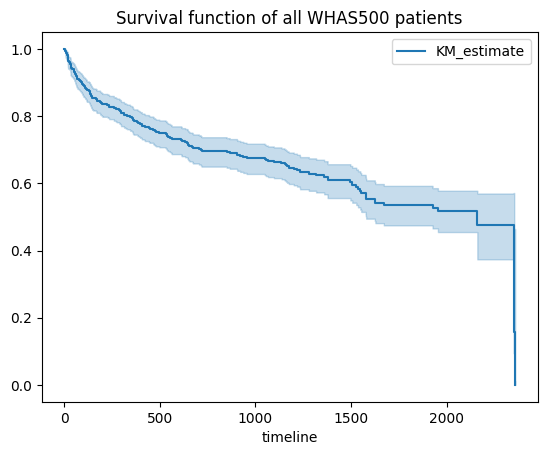

In [26]:
# General analysis of all patients
kmf = KaplanMeierFitter()
kmf.fit(durations = whas500['time'], 
        event_observed=whas500['event'])
kmf.plot_survival_function()
plt.title('Survival function of all WHAS500 patients')

print("Median survival time of all WHAS500 patients is {}days".format(kmf.median_survival_time_))

Text(0.5, 1.0, 'Survival based on first vs recurrent MI')

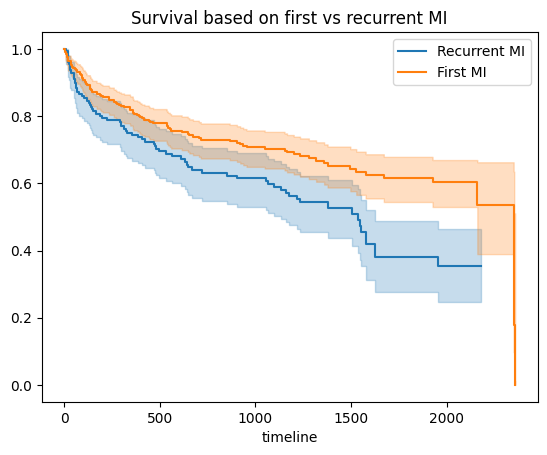

In [44]:
# Compare survival based on first vs recurrent MI 
recurrentMI = plt.subplot(111)

pts_recurrentMI = (whas500["fac_miord"] == "1")

kmf.fit(durations = whas500[pts_recurrentMI]['time'],
        event_observed = whas500[pts_recurrentMI]['event'], 
        label="Recurrent MI")
kmf.plot_survival_function(ax=recurrentMI)

kmf.fit(durations = whas500[~pts_recurrentMI]['time'],
        event_observed = whas500[~pts_recurrentMI]['event'], 
        label="First MI")
kmf.plot_survival_function(ax=recurrentMI)

plt.title("Survival based on first vs recurrent MI")